In [148]:
%matplotlib inline
import glob, os, sys
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const

from astropy.io import fits
from astropy.io.fits import getdata
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astroquery.skyview import SkyView
from astropy.table import vstack
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

from photutils import SkyCircularAperture
from photutils import make_source_mask
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats

plt.rcParams['axes.linewidth'] = 1.5

### Get multi-wavelength images

In [43]:
#SkyView.list_surveys()

In [146]:
coord = SkyCoord.from_name('NGC 4395')
bands = ['2MASS-J', '2MASS-H', '2MASS-K',
         'WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22',
         ]
paths = SkyView.get_images(position=coord,
                           survey=bands)

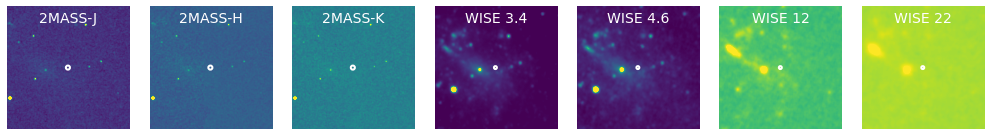

In [160]:
n_rows = len(paths)
fig,axs = plt.subplots(1,n_rows,figsize=(2*n_rows,2))

phot_table_list = []*n_rows

for i, hdul in enumerate(paths):
    data = hdul[0].data
    # Background subtraction
    mask = make_source_mask(data, nsigma=2, npixels=5, dilate_size=2)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    # Photometry
    aperture_sky = SkyCircularAperture(coord, r=5.0*u.arcsec)
    wcs = WCS(hdul[0].header)
    aperture = aperture_sky.to_pixel(wcs)
    phot_table = aperture_photometry(data-median, aperture)
    phot_table_list.append(phot_table)
    # Plot image
    axs[i].imshow(data, vmin=0.95*median, vmax=median + 5*np.std(data))
    aperture.plot(color='white', lw=2, axes=axs[i])
    axs[i].text(0.5,0.9, bands[i], fontsize=14, va='center', ha='center', transform=axs[i].transAxes, color='w')
    axs[i].axis('off')
fig.tight_layout()

phot_table_list = vstack(phot_table_list)

In [169]:
paths[0][0].header

SIMPLE  =                    T / Written by SkyView Sat Jun 27 06:05:26 EDT 2020
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =              186.435 / Reference longitude                            
CRVAL2  =               33.545 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

In [164]:
phot_table_list['aperture_sum']

27.906726903817233
42.70466422132118
37.4174424846761
55.801379194579084
20.37019557227783
116.95735232648555
2.769524216700689


TypeError: list indices must be integers or slices, not str

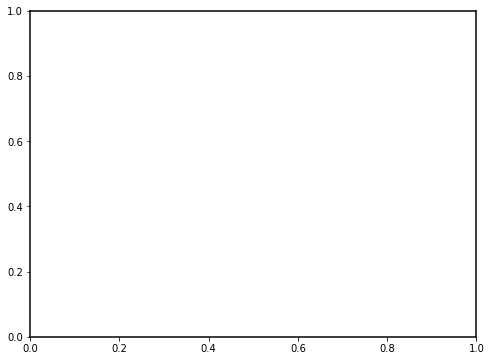

In [157]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(,phot_table_list['aperture_sum'])